In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import  *
import cv2

In [84]:
dataset_root = Path('./mnist_png')

all_files = dataset_root.rglob('*')
all_files = filter(lambda x: x.is_file(), all_files)
# all_files = list(all_files)

rows = []


for file in all_files:
    path = str(file)
    label = int(file.parent.name)
    split = file.parent.parent.name
    rows.append({
        'path': path,
        'label': label,
        'split': split
    })
    
df = pd.DataFrame(rows).sample(frac=1)
df

,path,label,split
50868,mnist_png/train/3/19445.png,3,train
11496,mnist_png/train/2/59415.png,2,train
46328,mnist_png/train/3/46729.png,3,train
26099,mnist_png/train/6/22178.png,6,train
2854,mnist_png/test/6/1491.png,6,test
...,...,...,...
6374,mnist_png/test/3/6801.png,3,test
45562,mnist_png/train/7/36916.png,7,train
5539,mnist_png/test/7/1477.png,7,test
21459,mnist_png/train/0/15407.png,0,train


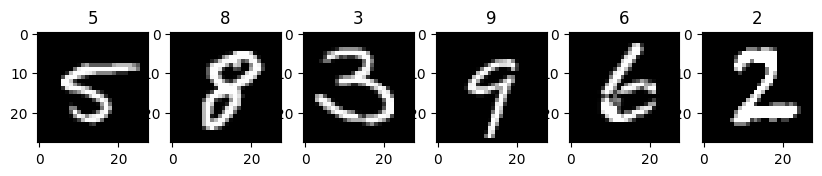

In [87]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(10, 6))

i = 0
for idx, row in df.sample(6).iterrows():
    img = cv2.imread(row.path)
    ax[i].imshow(img)
    ax[i].set_title(row.label)
    i += 1

In [88]:
df_train = df[df.split == 'train']
df_test = df[df.split == 'test']

df_train.shape, df_test.shape

((60000, 3), (10000, 3))

In [39]:
224*224*32/8*1000000/1024/1024/1024

186.920166015625

In [56]:
samples = [1,2,3,4,5]

ds = tf.data.Dataset.from_tensor_slices(samples)
ds = ds.map(lambda x: x**2)

for x in ds:
    print(x)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)


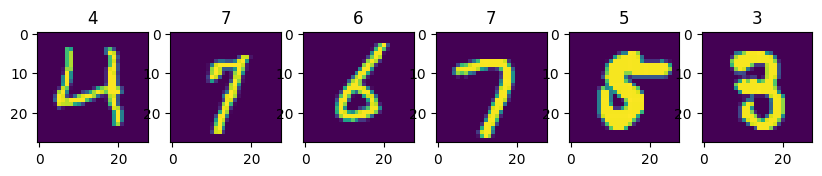

In [124]:
def make_dataset(df_to_use, batch_size=None, train=True):
    paths = df_to_use.path
    labels = df_to_use.label

    ds_x = tf.data.Dataset.from_tensor_slices(paths)
      
    ds_x = ds_x.map(lambda x: tf.io.read_file(x))
    ds_x = ds_x.map(lambda x: tf.image.decode_png(x))
    
    # if train:
    #     ds_x = ds_x.map(lambda x: tf.image.random_flip_left_right(x))
    
    ds_x = ds_x.map(lambda x: tf.reshape(x, [28, 28, 1]))
    ds_x = ds_x.map(lambda x: x/255)

    ds_y = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((ds_x, ds_y))
    ds = ds.shuffle(32)
    
    if batch_size is not None:
        ds = ds.batch(batch_size, drop_remainder=True)
        
    return ds



ds_train = make_dataset(df_train)
ds_test = make_dataset(df_test)

fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(10, 6))

for _ax, sample in zip(ax, ds_train.take(6)):
    img = sample[0]
    label = sample[1]
    _ax.imshow(img)
    _ax.set_title(int(label))

# ds_train = make_dataset(df_train, batch_size=32)
# ds_train

In [112]:
# 10000/32

312.5

In [120]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),  # [bs, W, H, D]
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),  # [bs, W, H, 16]
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # [bs, ~W/2, ~H/2, 16]
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # [bs, ~W/2, ~H/2, 32]
    
    tf.keras.layers.Flatten(),  # [bs, X]
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# model.build(input_shape=(None, 28, 28, 1))

# tf.keras.utils.plot_model(model, show_shapes=True)

ds_train = make_dataset(df_train, batch_size=32)
ds_test = make_dataset(df_test, batch_size=32)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(ds_train, validation_data=ds_test, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1228 - accuracy: 0.9622 - val_loss: 0.0525 - val_accuracy: 0.9834
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0371 - val_accuracy: 0.9884
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.0374 - val_accuracy: 0.9886
Epoch 4/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0435 - val_accuracy: 0.9875
Epoch 5/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0151 - accuracy: 0.9955 - val_loss: 0.0348 - val_accuracy: 0.9901


6/6 [==============================] - 0s 3ms/step


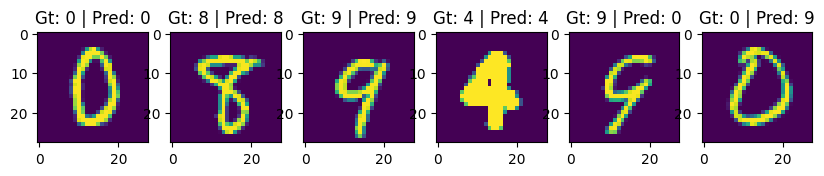

In [134]:
ds_test = make_dataset(df_test.sample(6)).batch(1)

preds = model.predict(ds_test)

preds = np.argmax(preds, axis=1)

fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(10, 6))

for _ax, sample, y_pred in zip(ax, ds_test.take(6), preds):
    _ax.imshow(sample[0][0])
    
    title = f'Gt: {int(sample[1])} | Pred: {y_pred}'
    _ax.set_title(title)